In [1]:
import sys
sys.path.append('../../ml_utils')

import config as cfg
import data_utils as du
import numpy as np
import pandas as pd
import timeit
import matplotlib.pyplot as plt
import joblib
import sklearn

from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score

%matplotlib inline

In [2]:
print("joblib (0.14.1): {}\n".format(joblib.__version__))
print("numpy (1.17.4): {}\n".format(np.__version__))
print("pandas (0.25.3): {}\n".format(pd.__version__))
print("sklearn (0.22): {}\n".format(sklearn.__version__))

joblib (0.14.1): 0.14.1

numpy (1.17.4): 1.17.4

pandas (0.25.3): 0.25.3

sklearn (0.22): 0.22



In [3]:
log_data = './../../shared/data/swissid_authorize_logs_april_to_sept_2019.csv'

start = timeit.default_timer()
df = pd.read_csv(filepath_or_buffer=log_data, header=0, sep='\t', names=cfg.complete_feature_list, index_col=None)
stop = timeit.default_timer()

print("Original data frame size: {}\n".format(df.shape))
print("Time: {} seconds\n".format(stop - start))

Original data frame size: (12417597, 31)

Time: 39.43312058299853 seconds



In [4]:
df = du.clean_data(df)

columns with NaN: loc_country_code
loc_country_code is fixed


Build the feature list

In [5]:
features = ['label_nr', 'src_software_sub_type', 'src_operating_system_name', 'src_hardware_type', 'response_status_code', 
            'oidc_client_id', 'oidc_scopes', 'oidc_ui_locales', 'loc_city', 'loc_country_code', 'date_weekday']

excludes = list(set(df.columns.tolist()) - set(features))

In [6]:
reduced_df = du.reduce_features(df, excludes)

print("reduced data frame size: {}\n".format(reduced_df.shape))
#display(reduced_df)

reduced data frame size: (12204748, 11)



Look at the 'label' distribution

In [7]:
print(reduced_df['label_nr'].value_counts())

2    7412813
0    4769169
1      22766
Name: label_nr, dtype: int64


Build the training, test, validation and novelties data frames. But before we shuffling the data 3 times and encode all categorial data.

In [8]:
training_size = 500000
validation_size = 100000
novelties_size = 40000

exclude = ['label_nr']

start = timeit.default_timer()
X_df, y_df, X_val_df, y_val_df, X_nov_df, y_nov_df, encoder = du.build_normal_and_novelty_sample_df(reduced_df, training_size, validation_size, novelties_size, exclude)
stop = timeit.default_timer()

runtime = stop - start

print("Time: {} seconds\n".format(runtime))
print("Time: {} minutes\n".format(runtime/60))

shuffling data...
encode dataframe...
encoding src_operating_system_name
encoding src_software_sub_type
encoding src_hardware_type
encoding oidc_client_id
encoding oidc_scopes
encoding oidc_ui_locales
encoding loc_city
encoding loc_country_code
build data sets...
Time: 31.774012989000767 seconds

Time: 0.5295668831500128 minutes



In [9]:
print("x_df size: {}\n".format(X_df.shape))
print(y_df.value_counts())
print()

print("x_val_df size: {}\n".format(X_val_df.shape))
print(y_val_df.value_counts())
print()

print("x_nov_df size: {}\n".format(X_nov_df.shape))
print(y_nov_df.value_counts())

x_df size: (500000, 10)

0    500000
Name: label_nr, dtype: int64

x_val_df size: (100000, 10)

0    100000
Name: label_nr, dtype: int64

x_nov_df size: (40000, 10)

1    20000
0    20000
Name: label_nr, dtype: int64


Split the training sample 80% / 20%

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X_df, y_df, test_size = 0.2, random_state = 42)
print("Shapes:\nx_train:%s\ny_train:%s\n" % (x_train.shape, y_train.shape))
print("x_test:%s\ny_test:%s\n" % (x_test.shape, y_test.shape))

Shapes:
x_train:(400000, 10)
y_train:(400000,)

x_test:(100000, 10)
y_test:(100000,)



### Hyperparameter optimization

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

parameters = {'kernel' : ['rbf', 'poly'], 'gamma' : [0.00005, 0.001, 0.01, 0.1, 1, 'scale'], 'nu': [0.001, 0.01, 0.1, 1],
              'verbose':[1], 'cache_size' : [10000]}
search = GridSearchCV(OneClassSVM(), parameters, cv=10, scoring='f1_micro', return_train_score=True)

count = 15000

start = timeit.default_timer()
search.fit(x_train[:count], y_train[:count])
stop = timeit.default_timer()

runtime = stop - start

print("Time: {} seconds\n".format(runtime))
print("Time: {} minutes\n".format(runtime/60))

result_df = pd.DataFrame(search.cv_results_)

print("Best parameters set:")
params = search.best_params_
print(params)

#result_df

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

### Fit the data with the One-Class-SVM algorithm based on GridSearchCV output

In [23]:
ocsvm_clf = OneClassSVM(kernel='rbf', gamma=0.00005, nu=0.001, cache_size=5000)
#ocsvm_clf = OneClassSVM(kernel='rbf', gamma=0.00005, nu=0.1, cache_size=5000)

start = timeit.default_timer()
ocsvm_clf.fit(x_train)
stop = timeit.default_timer()

runtime = stop - start

print("Time: {} seconds\n".format(runtime))
print("Time: {} minutes\n".format(runtime/60))

Time: 2207.910177672 seconds

Time: 36.7985029612 minutes



Predict the test data set and calculate the accuracy.
Normal are labeled 1, while anomalies are labeled -1

In [24]:
start = timeit.default_timer()
predictions = ocsvm_clf.predict(x_test)
stop = timeit.default_timer()

accuracy = du.calculate_accuracy_normal_df(y_test, predictions)
print("Accuracy: {:.2%}".format(accuracy))
print("Time: {} seconds\n".format(stop - start))

Accuracy: 89.75%
Time: 90.37157414400099 seconds



Predict the validation data set and calculate the accuracy.

In [25]:
start = timeit.default_timer()
predictions = ocsvm_clf.predict(X_val_df)
stop = timeit.default_timer()

accuracy = du.calculate_accuracy_normal_df(y_val_df, predictions)
print("Accuracy: {:.2%}".format(accuracy))
print("Time: {} seconds\n".format(stop - start))

Accuracy: 89.68%
Time: 90.23974452100083 seconds



This shows the bad ones:

In [26]:
y_nov_df.head(5)

11384417    1
12008254    1
12027725    1
5815366     1
8403416     1
Name: label_nr, dtype: int64

This show the good ones:

In [27]:
y_nov_df.tail(5)

1597323    0
6850493    0
6463607    0
9670202    0
965739     0
Name: label_nr, dtype: int64

Now predict totally new and mixed data:

In [28]:
predictions = ocsvm_clf.predict(X_nov_df)
scores = ocsvm_clf.score_samples(X_nov_df)

y_truth = y_nov_df.values == cfg.label_anomaly_idx

In [29]:
res, fpr_values, tpr_values = du.calc_best_threshold(y_truth, scores, 2)
res

{'best_auc': 0.97535,
 'best_auc_threshold': 258.2225635966174,
 'best_f1_score': 0.9748212461695609,
 'best_f1_score_threshold': 258.2225635966174}

In [30]:
res_1 = du.calc_metrics(y_truth, du.convert_predictions(predictions))
res_1

{'total': 40000,
 'tot_anomaly': 20000,
 'tot_normal': 20000,
 'tpr_recall': 0.98615,
 'precision': 0.9053061599192141,
 'accuracy': 0.9415,
 'f1_score': 0.9440003829033646,
 'fnr': 0.01385,
 'tnr': 0.89685,
 'fpr': 0.10315,
 'conf_matrix': [[19723, 2063], [277, 17937]],
 'auc': 0.9414999999999999}

In [31]:
y_predictions = scores < res['best_auc_threshold']
res_2 = du.calc_metrics(y_truth, y_predictions)
res_2

{'total': 40000,
 'tot_anomaly': 20000,
 'tot_normal': 20000,
 'tpr_recall': 0.95435,
 'precision': 0.9961899791231733,
 'accuracy': 0.97535,
 'f1_score': 0.9748212461695609,
 'fnr': 0.04565,
 'tnr': 0.99635,
 'fpr': 0.00365,
 'conf_matrix': [[19087, 73], [913, 19927]],
 'auc': 0.97535}

In [32]:
y_predictions = scores < res['best_f1_score_threshold']
res_3 = du.calc_metrics(y_truth, y_predictions)
res_3

{'total': 40000,
 'tot_anomaly': 20000,
 'tot_normal': 20000,
 'tpr_recall': 0.95435,
 'precision': 0.9961899791231733,
 'accuracy': 0.97535,
 'f1_score': 0.9748212461695609,
 'fnr': 0.04565,
 'tnr': 0.99635,
 'fpr': 0.00365,
 'conf_matrix': [[19087, 73], [913, 19927]],
 'auc': 0.97535}

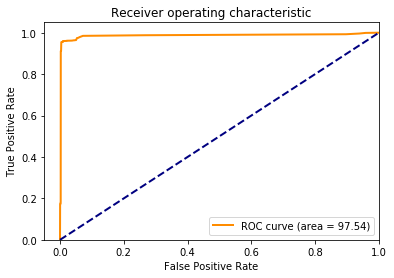

In [33]:
plt.figure()
plt.plot(fpr_values, tpr_values, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % (100*res_3['auc']))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## Persist the classifier

In [34]:
path_clf = './../../shared/models/ocsvm/optimized_ocsvm_encoded_clf_all.pkl'
path_enc = './../../shared/models/ocsvm/optimized_ocsvm_encoder_all.pkl'

# save the classifier to disk
joblib.dump(ocsvm_clf, path_clf)
joblib.dump(encoder, path_enc)

['./../../shared/models/ocsvm/optimized_ocsvm_encoder_all.pkl']

## Reload the classifier and predict
predict again to test if all works fine

In [35]:
# load the classifier from disk
loaded_clf = joblib.load(path_clf)

Test the performance with the reloaded model

In [36]:
predictions = loaded_clf.predict(X_nov_df)

y_truth = y_nov_df.values == cfg.label_anomaly_idx
res = du.calc_metrics(y_truth, du.convert_predictions(predictions))
res

{'total': 40000,
 'tot_anomaly': 20000,
 'tot_normal': 20000,
 'tpr_recall': 0.98615,
 'precision': 0.9053061599192141,
 'accuracy': 0.9415,
 'f1_score': 0.9440003829033646,
 'fnr': 0.01385,
 'tnr': 0.89685,
 'fpr': 0.10315,
 'conf_matrix': [[19723, 2063], [277, 17937]],
 'auc': 0.9414999999999999}